## Lasso regularization

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook, we will use Lasso to reduce the number of features and increase interpretability.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_regression, r_regression, SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

## House price

In [2]:
# load dataset
data = pd.read_csv('../houseprice_prep.csv')
data.shape

data.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,MiscFeature_Shed,SaleType_COD,SaleType_New,SaleType_Rare,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Rare
0,65.0,8450,7,5,5,5,196.0,4,3,4,...,0,0,0,0,1,0,0,1,0,0
1,80.0,9600,6,8,31,31,0.0,3,3,4,...,0,0,0,0,1,0,0,1,0,0
2,68.0,11250,7,5,7,6,162.0,4,3,4,...,0,0,0,0,1,0,0,1,0,0
3,60.0,9550,7,5,91,36,0.0,3,3,3,...,0,0,0,0,1,1,0,0,0,0
4,84.0,14260,8,5,8,8,350.0,4,3,4,...,0,0,0,0,1,0,0,1,0,0


In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['SalePrice'], axis=1), # predictive variables
    data['SalePrice'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((1314, 204), (146, 204))

In [4]:
# Scale data

scaler = MinMaxScaler().set_output(transform="pandas").fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Select features with Lasso

In [5]:
# here I will do the model fitting and feature selection
# altogether in one line of code

# first I specify the Logistic Regression model, and I
# make sure I select the Lasso (l1) penalty.

# Then I use the selectFromModel class from sklearn, which
# will select the features which coefficients are non-zero

sel_ = SelectFromModel(Lasso(alpha=0.5, random_state=10))

sel_.fit(X_train, y_train)

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+11, tolerance: 8.204e+08
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.5, random_state=10))

In [6]:
# Now I make a list with the selected features
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((len(X_train.columns))))
print('selected features: {}'.format(len(sel_.get_feature_names_out())))

total features: 204
selected features: 186


In [7]:
sel_.estimator_.score(X_train, y_train)

0.8966677282886497

In [8]:
sel_.estimator_.score(X_test, y_test)

0.754562651658298

## Optimize interpretability

In [9]:
alphas =[0.001, 0.1, 1, 10, 100, 500, 1000, 10000]

In [10]:
n_feat = []
r_train = []
r_test = []

for a in alphas:

    sel_ = SelectFromModel(Lasso(alpha=a, random_state=10))

    sel_.fit(X_train, y_train)

    n_feat.append(len(sel_.get_feature_names_out()))
    r_train.append(sel_.estimator_.score(X_train, y_train))
    r_test.append(sel_.estimator_.score(X_test, y_test))

n_feat

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.235e+11, tolerance: 8.204e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.029e+11, tolerance: 8.204e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[198, 193, 182, 165, 99, 45, 27, 3]

In [11]:
scores = pd.DataFrame({
    "n_feat": pd.Series(n_feat),
    "r_train": pd.Series(r_train),
    "r_test": pd.Series(r_test),
})

scores

,n_feat,r_train,r_test
0,198,0.896722,0.752775
1,193,0.896713,0.753134
2,182,0.896591,0.756270
3,165,0.894298,0.779702
4,99,0.878906,0.807615
5,45,0.843190,0.795660
6,27,0.807537,0.758126
7,3,0.297567,0.247264


Text(0, 0.5, 'r2 in test set')

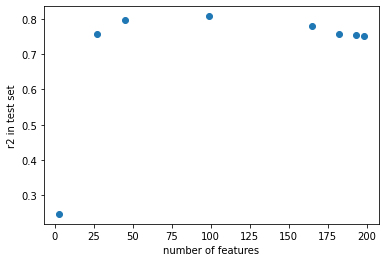

In [12]:
plt.scatter(scores["n_feat"], scores["r_test"])
plt.xlabel("number of features")
plt.ylabel("r2 in test set")

### Obtain the error on the performance

In [13]:
n_feat_mean = []
n_feat_std = []
r_test_mean = []
r_test_std = []

for a in alphas:

    sel_ = Pipeline([
        ("selector", SelectFromModel(Lasso(alpha=a, random_state=10))),
        ("lasso", Lasso(alpha=a, random_state=10))])

    results = cross_validate(
        estimator=sel_,
        X=X_train,
        y=y_train,
        scoring="r2",
        cv=5,
        return_estimator=True,
    )

    n_feat_mean.append(np.mean(
        [len(results["estimator"][i][:-1].get_feature_names_out()) for i in range(5)]))
    n_feat_std.append(np.std(
        [len(results["estimator"][i][:-1].get_feature_names_out()) for i in range(5)]))

    r_test_mean.append(np.mean(results["test_score"]))
    r_test_std.append(np.std(results["test_score"]))

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 6.571e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 6.571e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e+11, tolerance: 6.560e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e+11, tolerance: 6.560e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

In [14]:
scores = pd.DataFrame({
    "alpha": pd.Series(alphas),
    "n_feat_mean": pd.Series(n_feat_mean),
    "n_feat_std": pd.Series(n_feat_std),
    "r_test_mean": pd.Series(r_test_mean),
    "r_test_std": pd.Series(r_test_std),
})

scores

,alpha,n_feat_mean,n_feat_std,r_test_mean,r_test_std
0,0.001,197.4,0.800000,0.795699,0.066603
1,0.100,192.8,1.166190,0.795767,0.066924
2,1.000,183.0,1.549193,0.796574,0.069871
3,10.000,166.0,3.033150,0.806228,0.073295
4,100.000,99.2,6.305553,0.831999,0.046257
5,500.000,43.0,1.788854,0.817380,0.034262
6,1000.000,28.8,1.166190,0.788339,0.027860
7,10000.000,3.0,0.000000,0.290607,0.020160


Text(0, 0.5, 'r2 in test set')

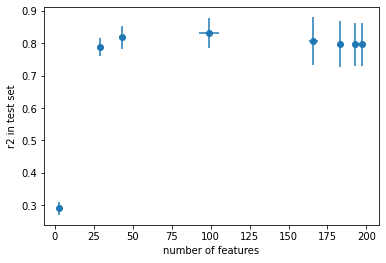

In [15]:
plt.errorbar(
    scores["n_feat_mean"],
    scores["r_test_mean"],
    xerr=scores["n_feat_std"],
    yerr=scores["r_test_std"],
    marker="o",
    ls = "",
    )

plt.xlabel("number of features")
plt.ylabel("r2 in test set")

In [16]:
alpha = 1000

model = Pipeline([
    ("selector", SelectFromModel(Lasso(alpha=alpha, random_state=10))),
    ("lasso", Lasso(alpha=alpha, random_state=10))])

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.7581270674457163

In [17]:
model.named_steps["lasso"].coef_

array([107781.199275  ,  -6245.5242489 ,  32842.26399941,  24961.4359886 ,
        17036.95123625,  95758.63568082,  10229.77984054,  35166.4248938 ,
        33580.61687055,  25017.83508726,   1919.04127675,  40156.04101346,
         2672.15471997,   1834.41459669,  -5839.82289538,  -4511.84697667,
         1559.73522404,  23857.67326478,  21193.26816352,    590.29358173,
         8935.35930355,  -4509.17572273,   5486.28200786,   -324.65059941,
         4281.72844623,  -2192.07892633,  12205.65355396])

In [18]:
model.named_steps["selector"].get_feature_names_out()

array(['OverallQual', 'YearRemodAdd', 'ExterQual', 'BsmtExposure',
       'BsmtFinType1', 'GrLivArea', 'FullBath', 'KitchenQual',
       'TotRmsAbvGrd', 'FireplaceQu', 'GarageFinish', 'GarageCars',
       'MSSubClass_20', 'MSSubClass_60', 'MSZoning_RM', 'LotShape_Reg',
       'LotConfig_CulDSac', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Condition1_Norm', 'BldgType_1Fam',
       'RoofStyle_Gable', 'RoofStyle_Hip', 'MasVnrType_Missing',
       'Foundation_PConc', 'GarageType_Detchd', 'SaleType_New'],
      dtype=object)

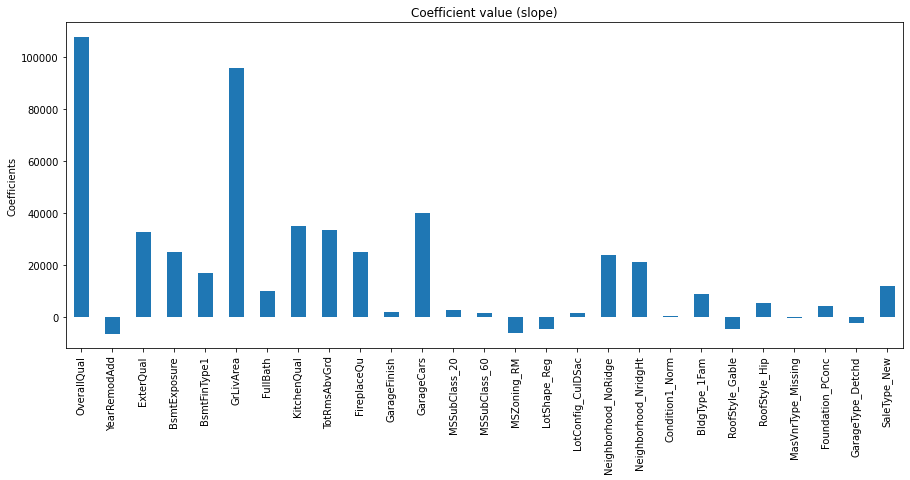

In [19]:
s = pd.Series(
    model.named_steps["lasso"].coef_,
    index=model.named_steps["selector"].get_feature_names_out(),
)

s.plot.bar(figsize=(15, 6))
plt.ylabel("Coefficients")
plt.title("Coefficient value (slope)")
plt.show()

- Calculate the Pearson correlation coefficient between features and target.
- Calculate the error on the coefficients ==> t and the p-values
- Investigate correlation among the features.

## Error in the coefficients

In [20]:
results = cross_validate(
    estimator=model,
    X=X_train,
    y=y_train,
    scoring="r2",
    cv=5,
    return_train_score=True,
    return_estimator=True,
)

results

{'fit_time': array([0.02100587, 0.01762724, 0.01797032, 0.01698756, 0.01797128]),
 'score_time': array([0.00397897, 0.00300169, 0.00299788, 0.00299883, 0.00301671]),
 'estimator': [Pipeline(steps=[('selector',
                   SelectFromModel(estimator=Lasso(alpha=1000, random_state=10))),
                  ('lasso', Lasso(alpha=1000, random_state=10))]),
  Pipeline(steps=[('selector',
                   SelectFromModel(estimator=Lasso(alpha=1000, random_state=10))),
                  ('lasso', Lasso(alpha=1000, random_state=10))]),
  Pipeline(steps=[('selector',
                   SelectFromModel(estimator=Lasso(alpha=1000, random_state=10))),
                  ('lasso', Lasso(alpha=1000, random_state=10))]),
  Pipeline(steps=[('selector',
                   SelectFromModel(estimator=Lasso(alpha=1000, random_state=10))),
                  ('lasso', Lasso(alpha=1000, random_state=10))]),
  Pipeline(steps=[('selector',
                   SelectFromModel(estimator=Lasso(alpha=1000, ran

In [21]:
# R2 in train set

print("R2 in train set: mean, std")
np.mean(results['train_score']), np.std(results['train_score'])

R2 in train set: mean, std


(0.8100383167131431, 0.008873293078310092)

In [22]:
# R2 in test set

print("R2 in test set: mean, std")
np.mean(results['test_score']), np.std(results['test_score'])

R2 in test set: mean, std


(0.7883391983198186, 0.027860388362836212)

In [23]:
results

{'fit_time': array([0.02100587, 0.01762724, 0.01797032, 0.01698756, 0.01797128]),
 'score_time': array([0.00397897, 0.00300169, 0.00299788, 0.00299883, 0.00301671]),
 'estimator': [Pipeline(steps=[('selector',
                   SelectFromModel(estimator=Lasso(alpha=1000, random_state=10))),
                  ('lasso', Lasso(alpha=1000, random_state=10))]),
  Pipeline(steps=[('selector',
                   SelectFromModel(estimator=Lasso(alpha=1000, random_state=10))),
                  ('lasso', Lasso(alpha=1000, random_state=10))]),
  Pipeline(steps=[('selector',
                   SelectFromModel(estimator=Lasso(alpha=1000, random_state=10))),
                  ('lasso', Lasso(alpha=1000, random_state=10))]),
  Pipeline(steps=[('selector',
                   SelectFromModel(estimator=Lasso(alpha=1000, random_state=10))),
                  ('lasso', Lasso(alpha=1000, random_state=10))]),
  Pipeline(steps=[('selector',
                   SelectFromModel(estimator=Lasso(alpha=1000, ran

In [24]:
# Collect coefficients in dataframe

coeffs = []

for estimator in results["estimator"]:

    dictionary = dict(
        zip(
            estimator.named_steps["selector"].get_feature_names_out(),
            estimator.named_steps["lasso"].coef_, 
        )
    )
    coeffs.append(dictionary)

In [25]:
coeffs = pd.DataFrame(coeffs).T

coeffs

,0,1,2,3,4
OverallQual,105089.543783,105090.053227,107422.031225,101836.922872,114465.293778
YearRemodAdd,-6572.887102,-1627.423199,-6942.000403,-6806.860919,-8970.172386
ExterQual,25846.395654,37411.910131,39251.177069,30701.481356,32416.191319
BsmtExposure,21658.654568,25020.124130,31991.706919,24074.140118,22834.182581
BsmtFinType1,17840.965134,17233.432053,13184.021448,17053.245284,18691.285780
GrLivArea,139253.915403,102625.685720,73374.161762,43840.244292,85216.170057
FullBath,12743.709815,7323.150390,7149.938926,15291.126882,11295.022985
KitchenQual,33969.471374,44316.124780,34877.267038,31422.646010,31706.824847
TotRmsAbvGrd,18370.305436,31055.378755,35906.161054,47171.002525,32516.256965
Fireplaces,4136.284124,NaN,NaN,NaN,NaN


In [26]:
coeffs.dropna(inplace=True)
coeffs[["mean", "std"]] = coeffs.agg(["mean", "std"], axis=1)
coeffs["t"] = coeffs["mean"] / coeffs["std"]

coeffs

,0,1,2,3,4,mean,std,t
OverallQual,105089.543783,105090.053227,107422.031225,101836.922872,114465.293778,106780.768977,4733.484853,22.558595
YearRemodAdd,-6572.887102,-1627.423199,-6942.000403,-6806.860919,-8970.172386,-6183.868802,2722.081104,-2.271743
ExterQual,25846.395654,37411.910131,39251.177069,30701.481356,32416.191319,33125.431106,5367.997220,6.170911
BsmtExposure,21658.654568,25020.124130,31991.706919,24074.140118,22834.182581,25115.761663,4047.528188,6.205210
BsmtFinType1,17840.965134,17233.432053,13184.021448,17053.245284,18691.285780,16800.589940,2120.605219,7.922545
GrLivArea,139253.915403,102625.685720,73374.161762,43840.244292,85216.170057,88862.035447,35386.819152,2.511162
FullBath,12743.709815,7323.150390,7149.938926,15291.126882,11295.022985,10760.589799,3521.254730,3.055896
KitchenQual,33969.471374,44316.124780,34877.267038,31422.646010,31706.824847,35258.466810,5271.993747,6.687881
TotRmsAbvGrd,18370.305436,31055.378755,35906.161054,47171.002525,32516.256965,33003.820947,10335.697047,3.193188
FireplaceQu,21343.005060,25631.972142,24124.764361,25983.244556,26779.430546,24772.483333,2145.539674,11.546038


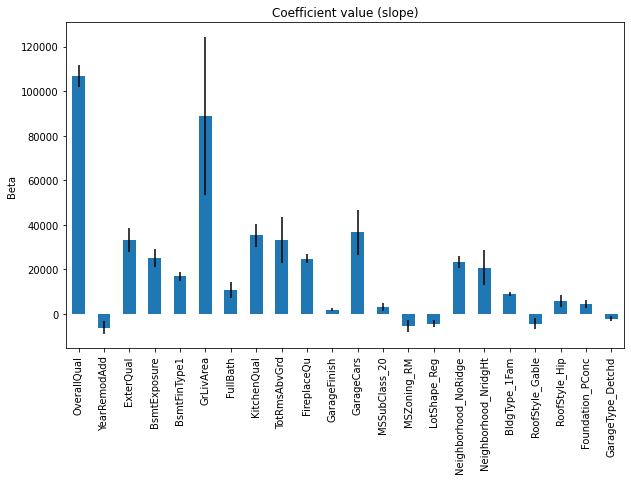

In [27]:
s = pd.Series(
    coeffs["mean"],
    index=coeffs.index,
)

s.plot.bar(yerr=coeffs["std"], figsize=(10,6))
plt.ylabel("Beta")
plt.title("Coefficient value (slope)")
plt.show()

The coefficients seem to have huge variability.

We could probably reduce the size of the error if instead of predicting house price, we predict the logarithm of house price. Would you like to try it out?

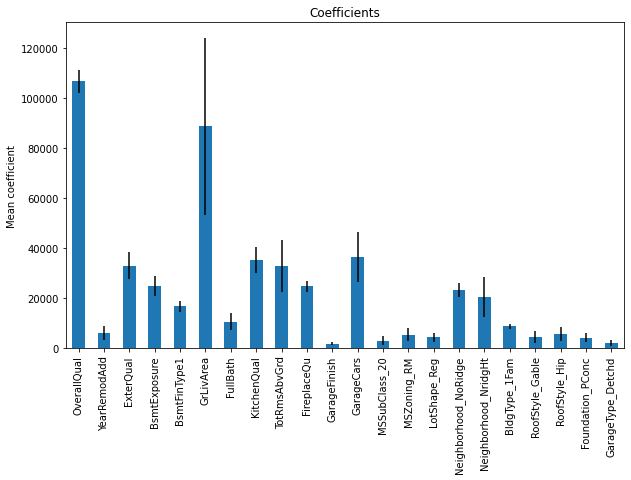

In [28]:
# plot mean coefficient plus std

coeffs["mean"].abs().plot.bar(yerr=coeffs["std"], figsize=(10,6))
plt.ylabel("Mean coefficient")
plt.title("Coefficients")
plt.show()

We could sort the features by the absolute value of the coefficient to have a better view of which features contribute the most to the house price.

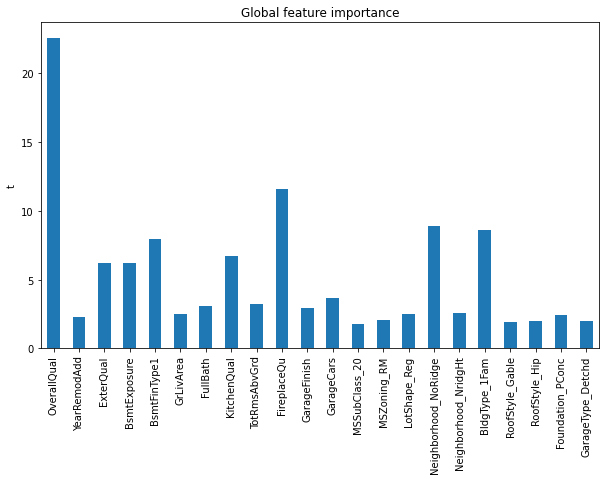

In [29]:
# plot t

coeffs["t"].abs().plot.bar(figsize=(10,6))
plt.ylabel("t")
plt.title("Global feature importance")
plt.show()

We can trust most predictors more or less the same according to the t values.